In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)

        # print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        #print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)


        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        deltaCenter =  torch.mean(torch.sum(deltaCenter1, dim=2), dim = 0) + torch.mean(torch.sum(deltaCenter2, dim=2), dim = 0)

        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_, R) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.weights -= self.lr * delta_weight
        #self.centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_num, 1)
        #self.sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_num, 1)
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    # R, pred = self.forward(input_data)
                    # rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

In [4]:
r_c = torch.tensor([1.32141, 6.1256142, 4.21512, 3.16512, 7.1626, 8.735, 12.1624], dtype = float ,device= device).reshape(7,1)
r_s = torch.tensor([1.1, 0.6142, 2.21512, 1.162, 0.626, 2.735, 1.1624], dtype = float ,device= device).reshape(7,1)
r_w = torch.tensor([[-10, 12, 32, -33, 12, -20, 3],
                    [12, -1, -22, 3, 32, -20, 4],
                    [-10, 3, 23, -13, 23, 17, 2]], dtype = float, device = device)
def rbf_gaussian(input_data):
    out = torch.exp(-1 *(torch.pow((input_data - r_c), 2)) / (torch.pow(r_s, 2)))

    return out
a = np.arange(0,15,0.05)
input_ = torch.tensor(a, device = device)
target = rbf_gaussian(input_)
target = torch.matmul(r_w, target)


In [5]:
def plot_data(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

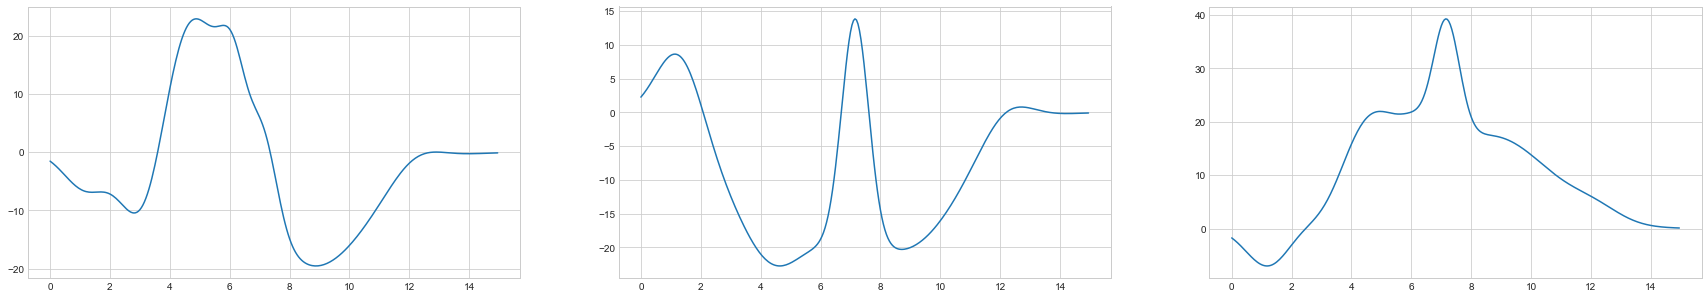

In [6]:
plot_data(input_, 3, target)

In [7]:
nomal_target = nn.functional.normalize(target, dim = 1)

In [9]:
nomal_target.size()

torch.Size([3, 300])

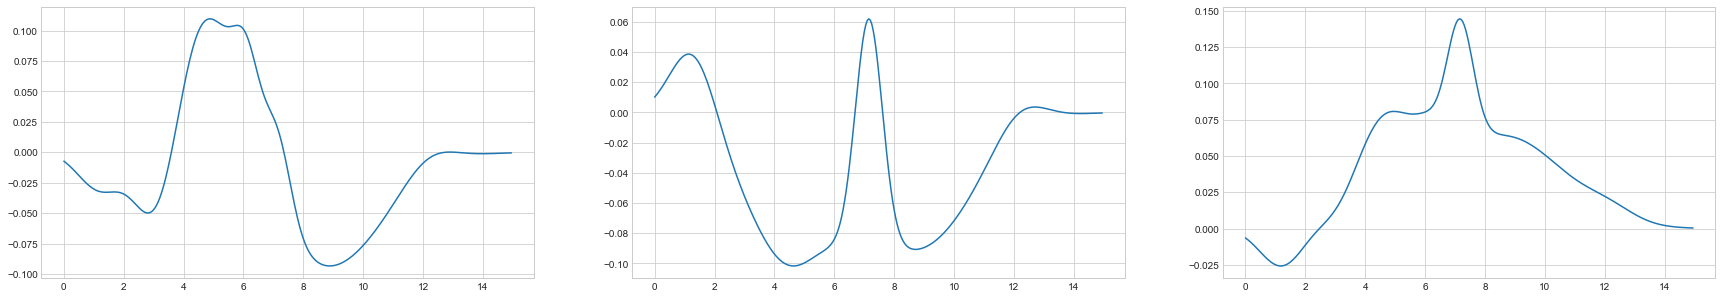

In [18]:
plot_data(input_, 3, nomal_target)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 0.3204149083980412
0th additional RBFlayer 999th epoch MSE Loss: 0.004358655260191165
0th additional RBFlayer 1999th epoch MSE Loss: 0.004210221683954852
0th additional RBFlayer 2999th epoch MSE Loss: 0.0041287928898863105
0th additional RBFlayer best loss : 0.0041287928898863105


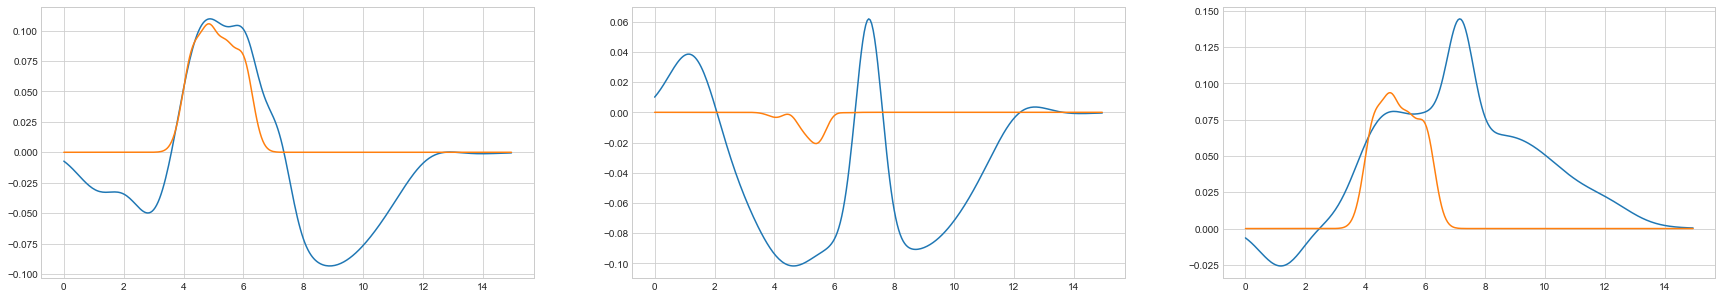

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 0.26522667434272656
1th additional RBFlayer 999th epoch MSE Loss: 0.0030821557418148357
1th additional RBFlayer 1999th epoch MSE Loss: 0.0030571517463214835
1th additional RBFlayer 2999th epoch MSE Loss: 0.003054116793784746
1th additional RBFlayer best loss : 0.003052657088079457


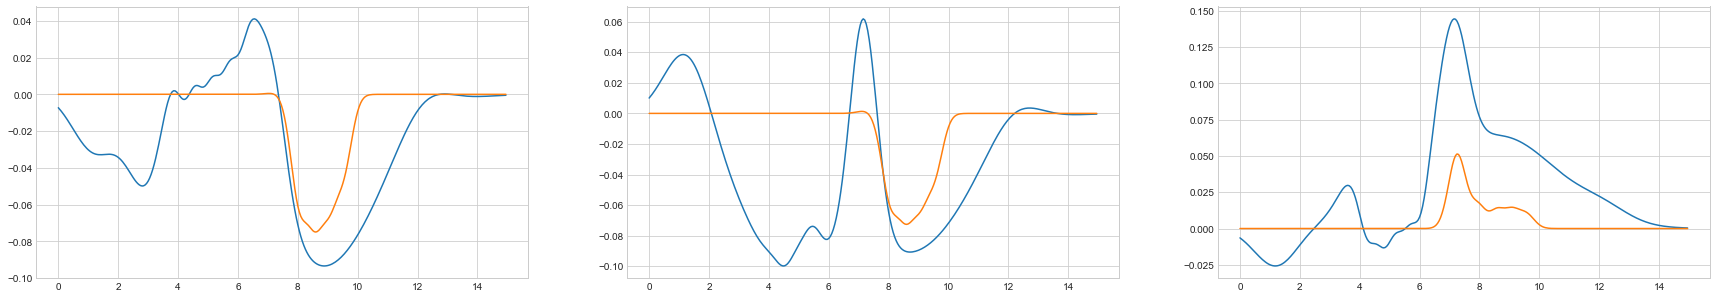

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 0.16896824909975933
2th additional RBFlayer 999th epoch MSE Loss: 0.0023208890691228776
2th additional RBFlayer 1999th epoch MSE Loss: 0.0023134149146522287
2th additional RBFlayer 2999th epoch MSE Loss: 0.002311568985261838
2th additional RBFlayer best loss : 0.0023115688332839435


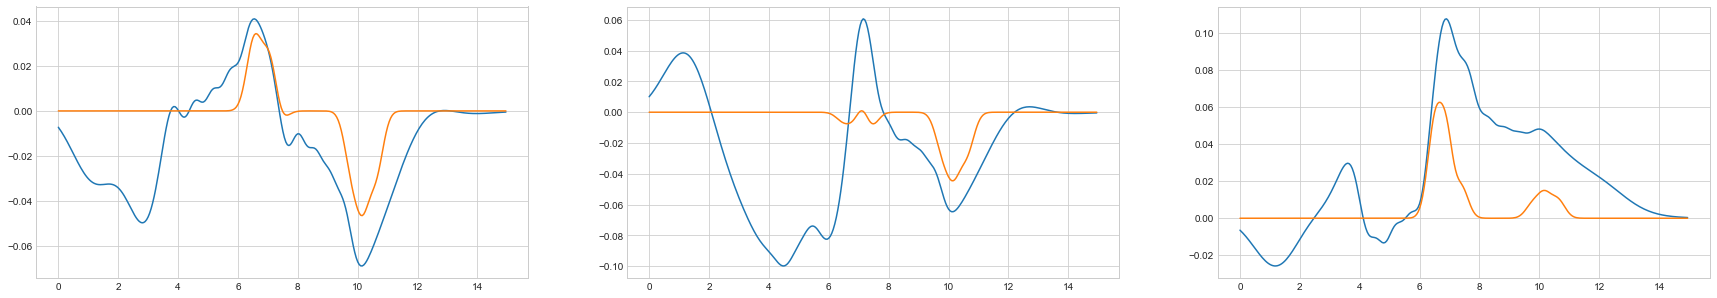

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 0.11131424381225014
3th additional RBFlayer 999th epoch MSE Loss: 0.0019270036870511148
3th additional RBFlayer 1999th epoch MSE Loss: 0.0019257182105485338
3th additional RBFlayer 2999th epoch MSE Loss: 0.0019410897510545142
3th additional RBFlayer best loss : 0.0019226618899328709
change lr  0.001
----------------------------------------------
change round number 6
----------------------------------------------


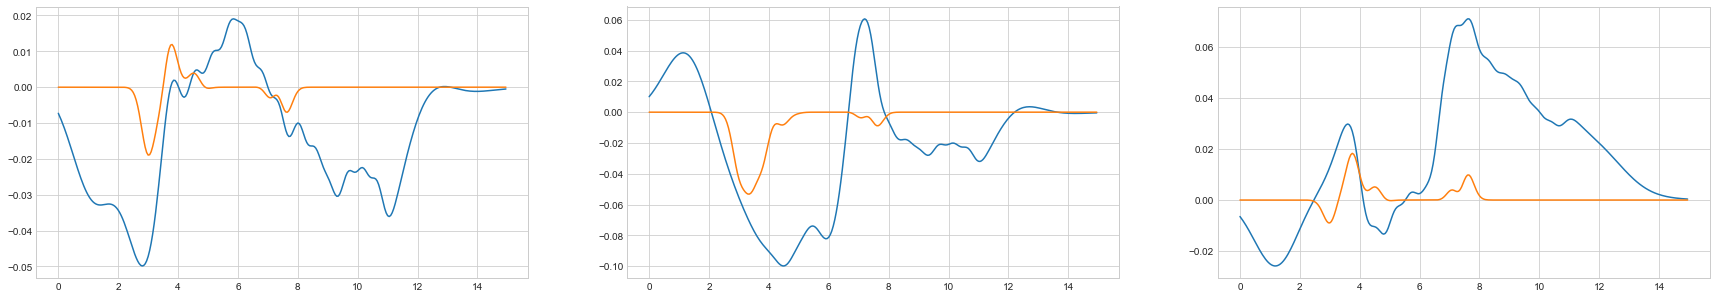

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 0.11064041886877908
4th additional RBFlayer 999th epoch MSE Loss: 0.0018355709441247418
4th additional RBFlayer 1999th epoch MSE Loss: 0.0018279330782078604
4th additional RBFlayer 2999th epoch MSE Loss: 0.0018380213708281811
4th additional RBFlayer best loss : 0.001824340962589725


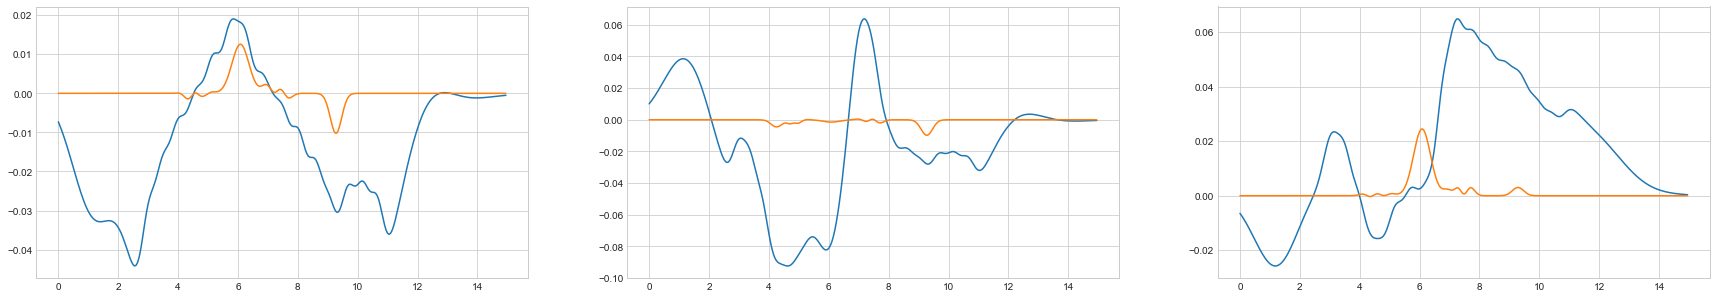

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 0.11786570587704268
5th additional RBFlayer 999th epoch MSE Loss: 0.0018090115566922371
5th additional RBFlayer 1999th epoch MSE Loss: 0.0018152061900827525
5th additional RBFlayer 2999th epoch MSE Loss: 0.0018191226394922697
5th additional RBFlayer best loss : 0.0018067212513271913


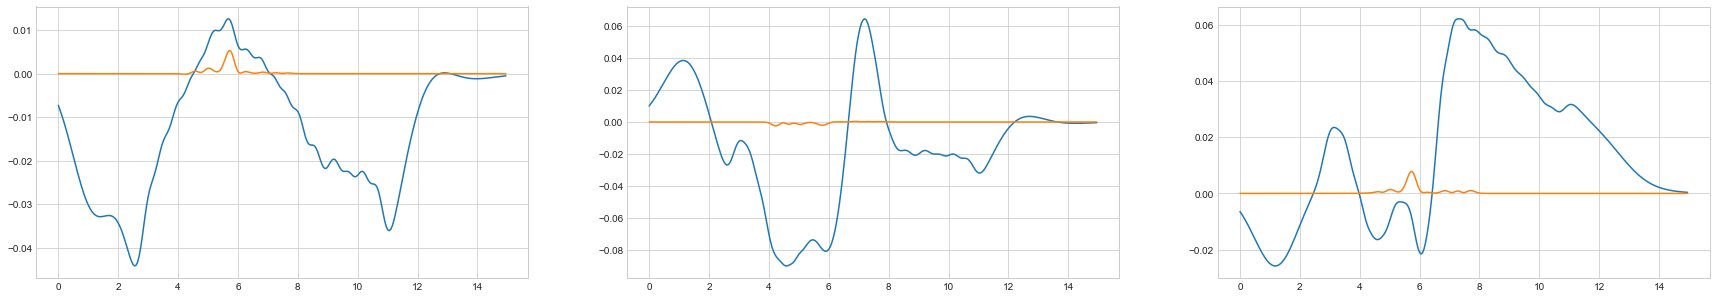

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 0.11796353395989576
6th additional RBFlayer 999th epoch MSE Loss: 0.0018040587455202752
6th additional RBFlayer 1999th epoch MSE Loss: 0.0018017952670942793
6th additional RBFlayer 2999th epoch MSE Loss: 0.0018034160478304956
6th additional RBFlayer best loss : 0.0018017727347129668


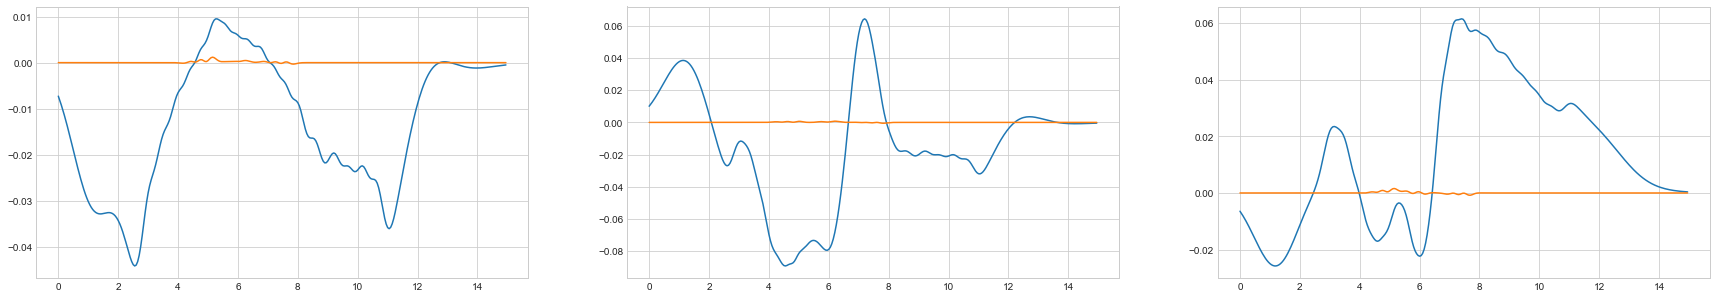

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 0.11897427330859227
7th additional RBFlayer 999th epoch MSE Loss: 0.0018006064138133902
7th additional RBFlayer 1999th epoch MSE Loss: 0.0018010518301825001
7th additional RBFlayer 2999th epoch MSE Loss: 0.0018012958712374403
7th additional RBFlayer best loss : 0.001800552989875413


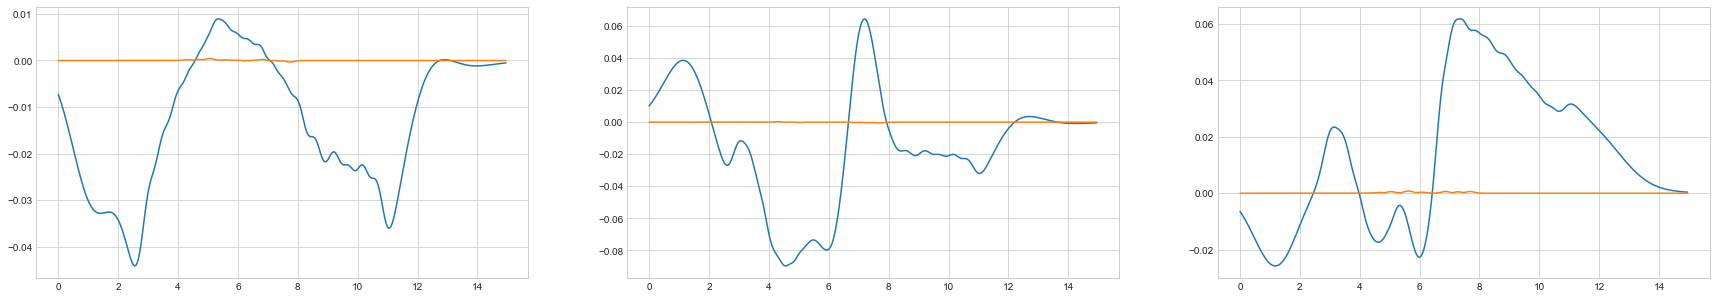

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 0.11889293103844469


KeyboardInterrupt: 

In [22]:
model_nomal1 = MultiRBFnn(nomal_target.size(0), 30, device)
model_nomal1.train(input_, nomal_target, 3000, 0.0001, 0.0001, 0.002)

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), nomal_target[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_nomal1.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

In [40]:
nomal_target2 = nn.functional.normalize(target.reshape(target.size(0) * target.size(1)), dim = 0)
nomal_target2 = nomal_target2.reshape(3,300)

In [37]:
nomal_target2[0] - nn.functional.normalize(target[0], dim = 0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

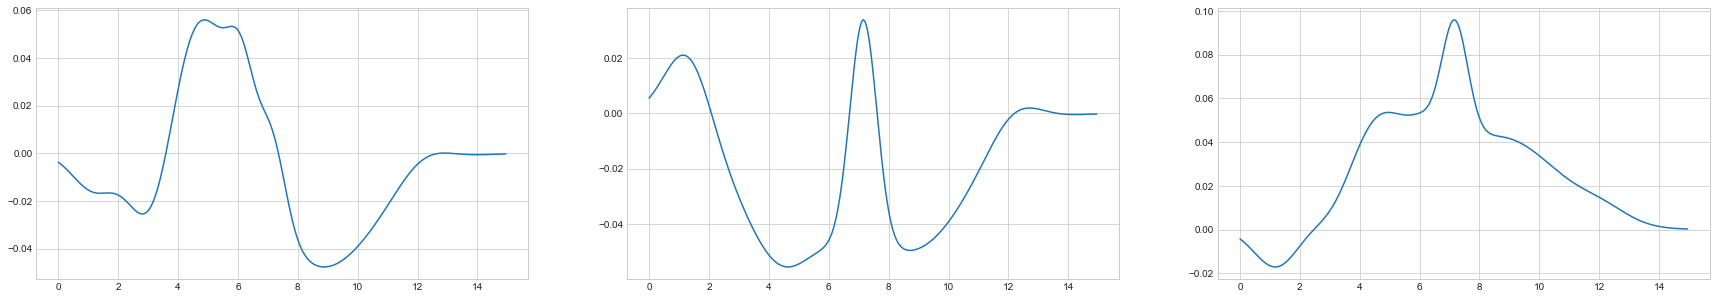

In [42]:
plot_data(input_, 3, nomal_target2)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 0.07692145602254767
0th additional RBFlayer 999th epoch MSE Loss: 0.001428980302395096
0th additional RBFlayer 1999th epoch MSE Loss: 0.0014102440253078831
0th additional RBFlayer 2999th epoch MSE Loss: 0.001392135031319104
0th additional RBFlayer best loss : 0.001392135031319104
change lr  0.001
----------------------------------------------


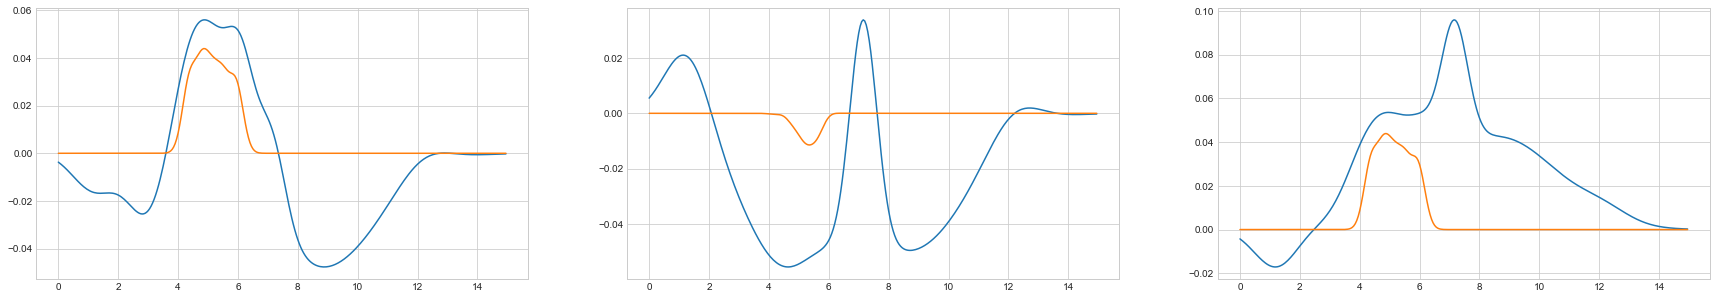

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 0.08816324401069736
1th additional RBFlayer 999th epoch MSE Loss: 0.001202639671660632
1th additional RBFlayer 1999th epoch MSE Loss: 0.0011990143332202665
1th additional RBFlayer 2999th epoch MSE Loss: 0.0011572635885783542
1th additional RBFlayer best loss : 0.0011571605715665347
change round number 6
----------------------------------------------


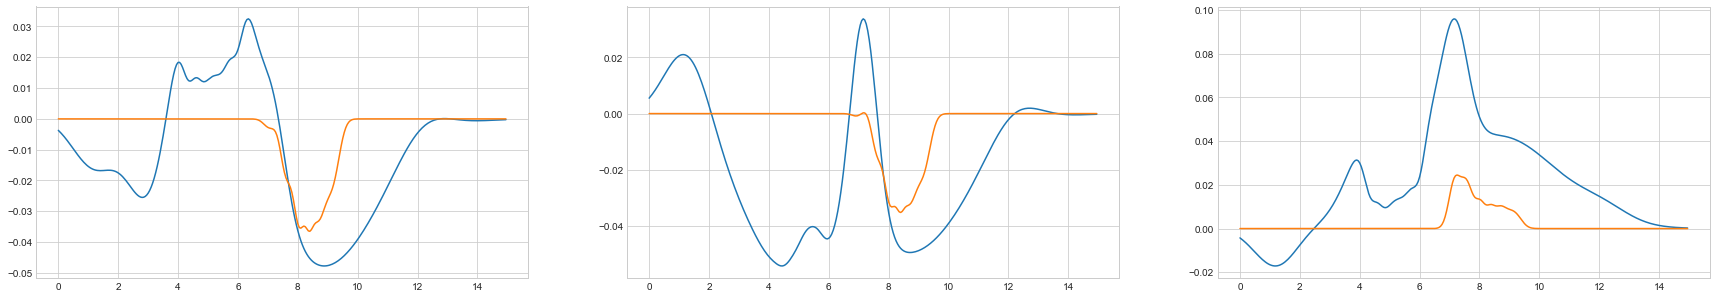

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 0.06880899672697573
2th additional RBFlayer 999th epoch MSE Loss: 0.0008816135757383836
2th additional RBFlayer 1999th epoch MSE Loss: 0.000894317315270719
2th additional RBFlayer 2999th epoch MSE Loss: 0.0009266533756538374
2th additional RBFlayer best loss : 0.0008655247299603392


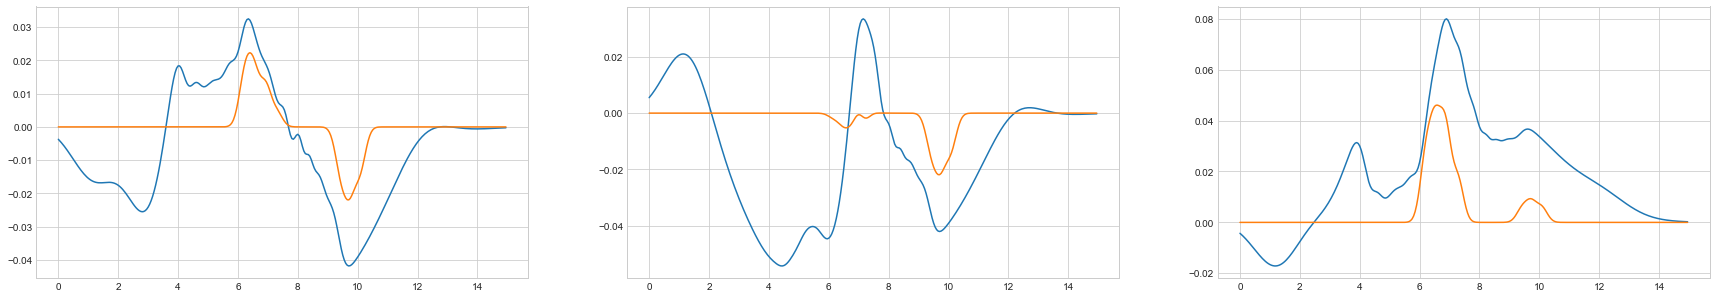

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 0.04753290402411447
3th additional RBFlayer 999th epoch MSE Loss: 0.0007565241246053074
3th additional RBFlayer 1999th epoch MSE Loss: 0.0007588753370064283
3th additional RBFlayer 2999th epoch MSE Loss: 0.0007614756943948745
3th additional RBFlayer best loss : 0.0007521350962692679


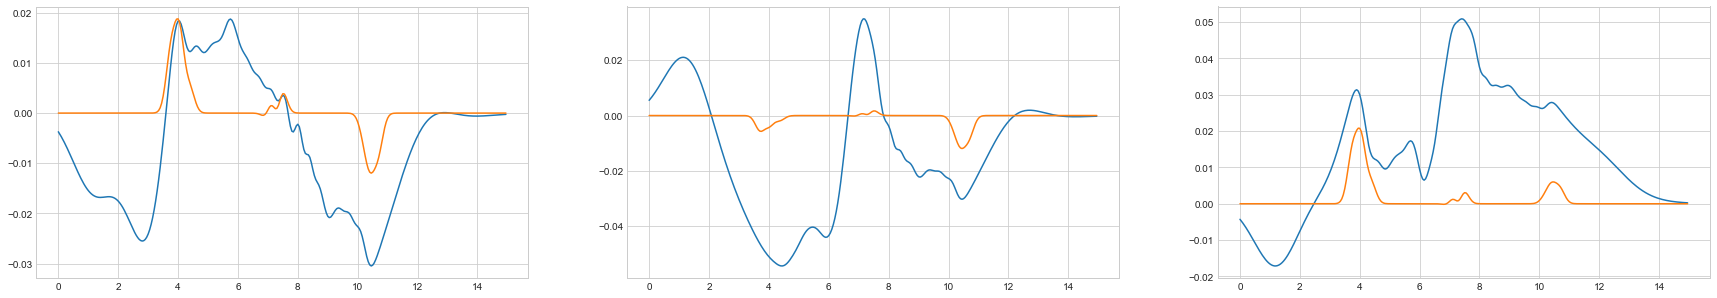

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 0.04075216027775243
4th additional RBFlayer 999th epoch MSE Loss: 0.0007061674384289021
4th additional RBFlayer 1999th epoch MSE Loss: 0.0007075507522206753
4th additional RBFlayer 2999th epoch MSE Loss: 0.0007062353837011844
4th additional RBFlayer best loss : 0.0007056356932928015


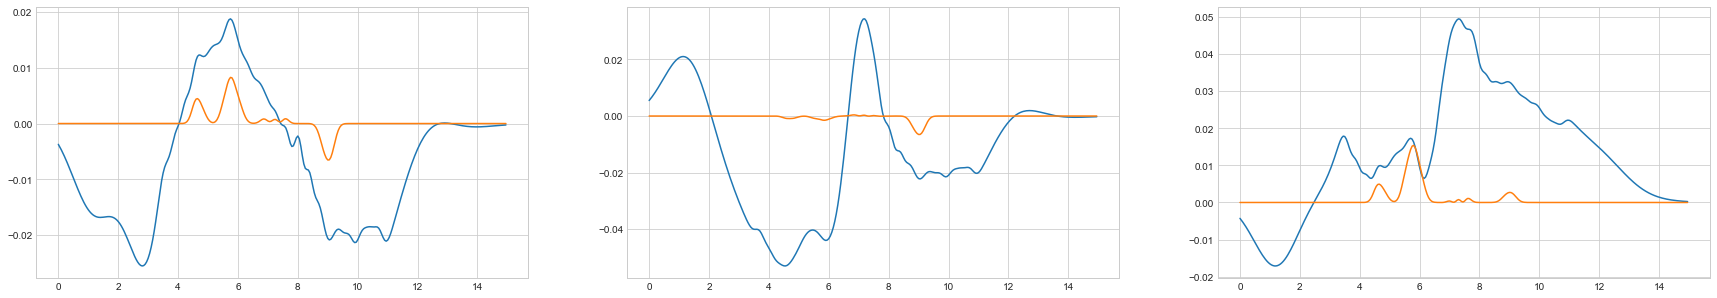

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 0.03244546031828444
5th additional RBFlayer 999th epoch MSE Loss: 0.0006660101717211813
5th additional RBFlayer 1999th epoch MSE Loss: 0.0006657958387526862
5th additional RBFlayer 2999th epoch MSE Loss: 0.0006664234208150879
5th additional RBFlayer best loss : 0.0006571072731227159


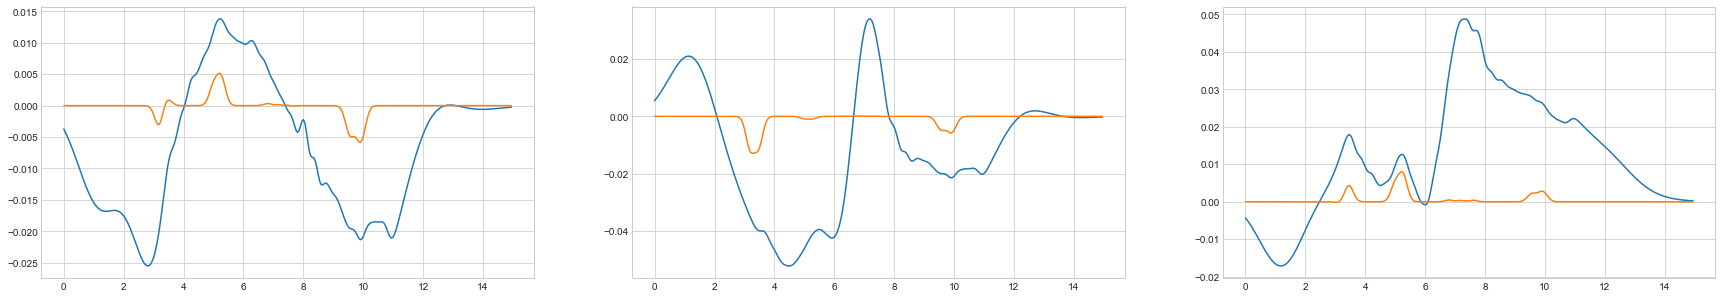

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 0.03249462732492008
6th additional RBFlayer 999th epoch MSE Loss: 0.00063395984884412
6th additional RBFlayer 1999th epoch MSE Loss: 0.0006329303708293694
6th additional RBFlayer 2999th epoch MSE Loss: 0.0006356604411161822
6th additional RBFlayer best loss : 0.0006323073756104489


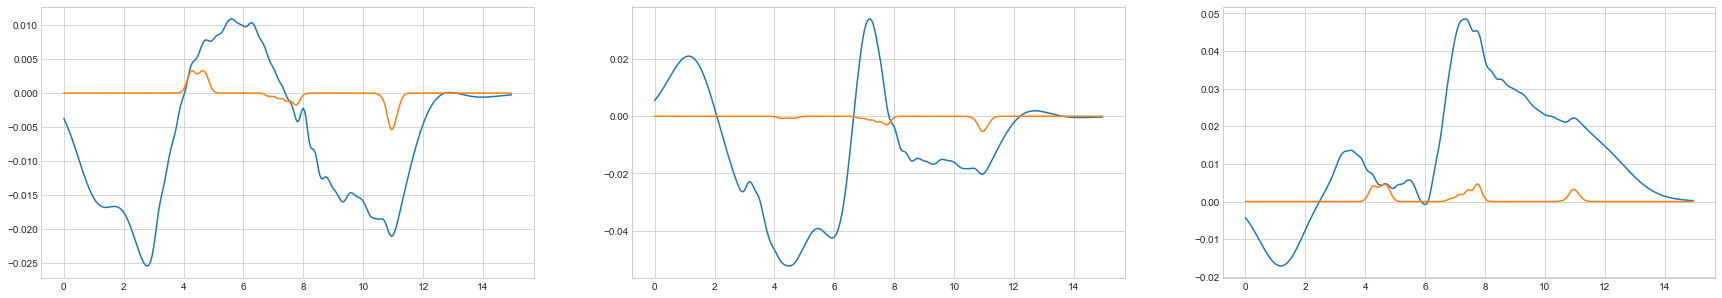

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 0.02129210843590272
7th additional RBFlayer 999th epoch MSE Loss: 0.0006206221926629575
7th additional RBFlayer 1999th epoch MSE Loss: 0.0006211112823380449
7th additional RBFlayer 2999th epoch MSE Loss: 0.0006212755053928398
7th additional RBFlayer best loss : 0.0006204795619578381


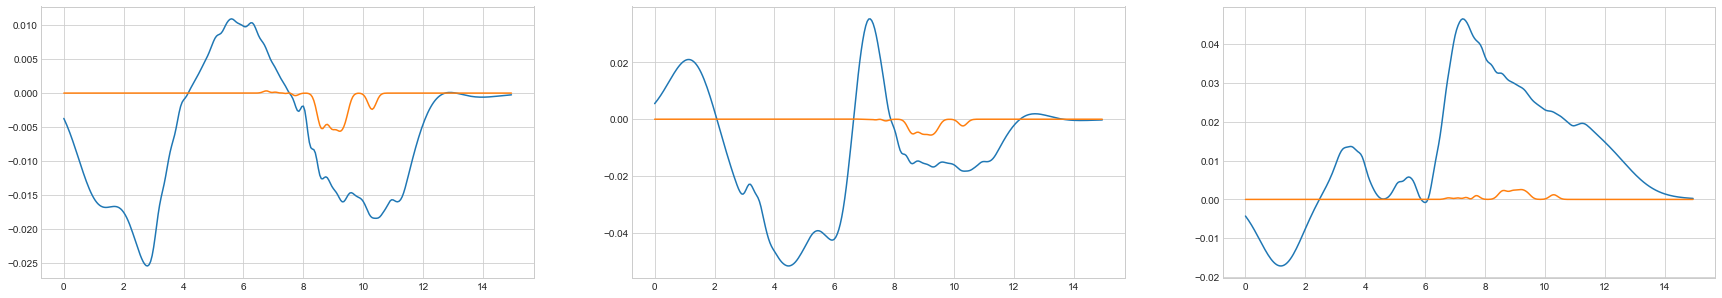

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 0.025645079671943027
8th additional RBFlayer 999th epoch MSE Loss: 0.0005865571297931745
8th additional RBFlayer 1999th epoch MSE Loss: 0.000589027908544015
8th additional RBFlayer 2999th epoch MSE Loss: 0.0005938265237418803
8th additional RBFlayer best loss : 0.0005792657684148723


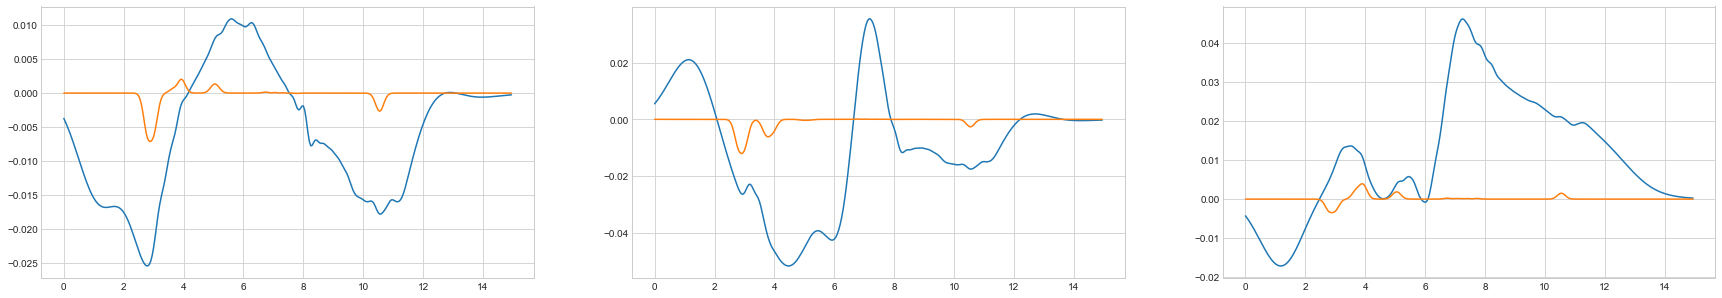

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 0.028655864695824866
9th additional RBFlayer 999th epoch MSE Loss: 0.0005726779542342326
9th additional RBFlayer 1999th epoch MSE Loss: 0.00057306916054711
9th additional RBFlayer 2999th epoch MSE Loss: 0.0005728085694532414
9th additional RBFlayer best loss : 0.0005725907192335142


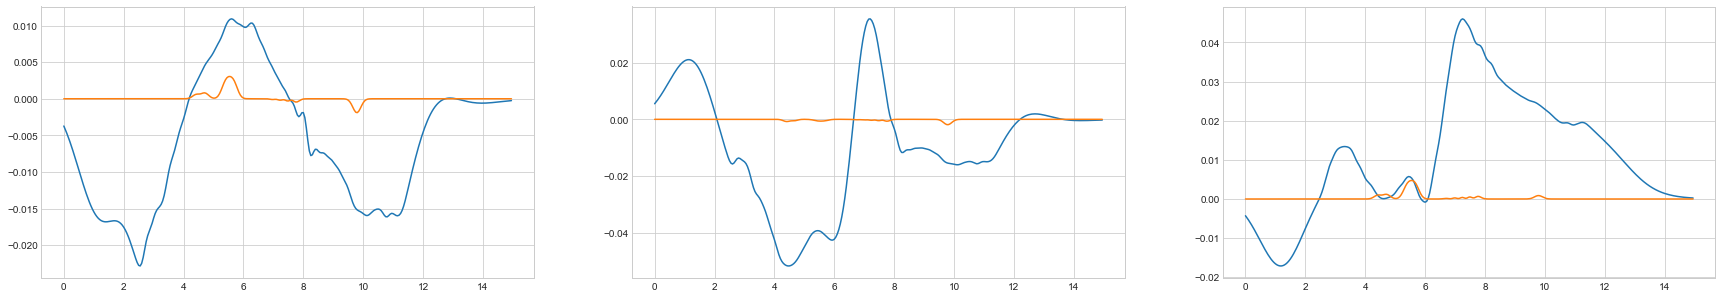

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 0.024809702135199514
10th additional RBFlayer 999th epoch MSE Loss: 0.0005663106598460748
10th additional RBFlayer 1999th epoch MSE Loss: 0.0005664204937315582
10th additional RBFlayer 2999th epoch MSE Loss: 0.0005684233416245185
10th additional RBFlayer best loss : 0.0005662689666173069


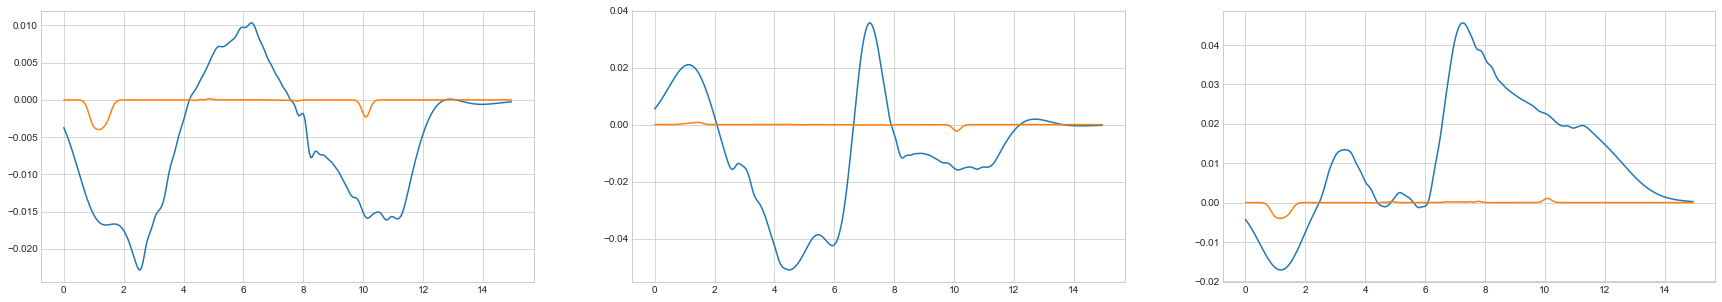

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 0.024809597983733202
11th additional RBFlayer 999th epoch MSE Loss: 0.0005581610549870996
11th additional RBFlayer 1999th epoch MSE Loss: 0.0005587219895254048
11th additional RBFlayer 2999th epoch MSE Loss: 0.0005594266350375555
11th additional RBFlayer best loss : 0.0005581044799576319


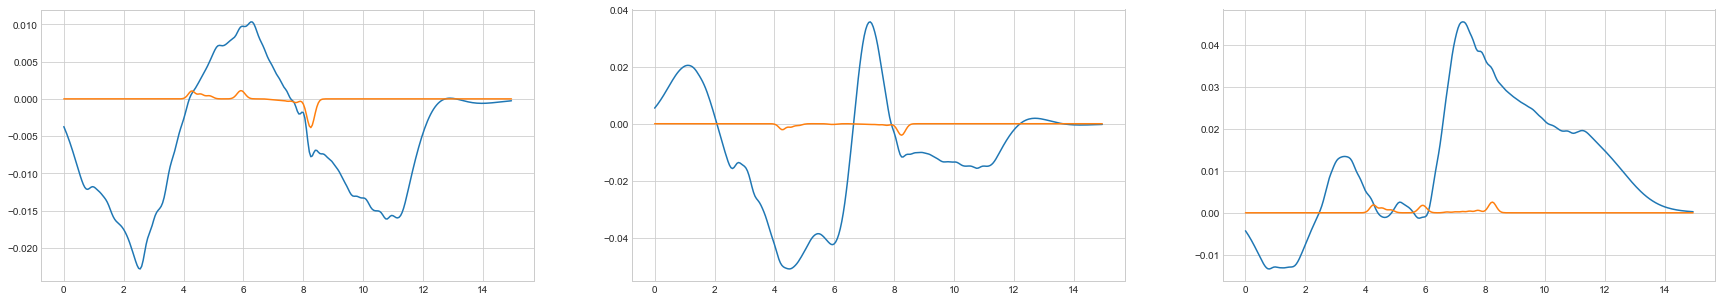

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 0.027168368622550846
12th additional RBFlayer 999th epoch MSE Loss: 0.0005576817888873843
12th additional RBFlayer 1999th epoch MSE Loss: 0.000557841517309109
12th additional RBFlayer 2999th epoch MSE Loss: 0.0005577772453107311
12th additional RBFlayer best loss : 0.0005576714553104644


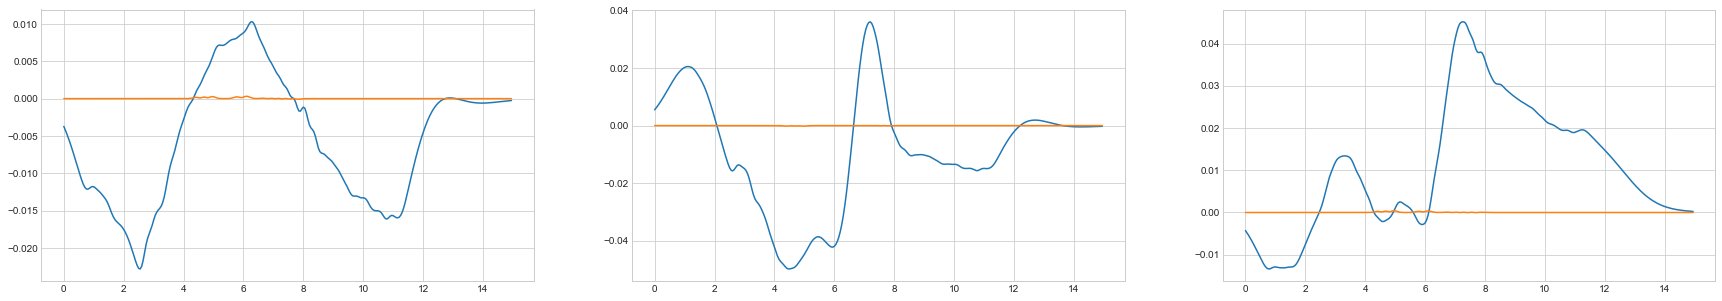

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 0.027060008340922342
13th additional RBFlayer 999th epoch MSE Loss: 0.000557473104344856
13th additional RBFlayer 1999th epoch MSE Loss: 0.0005575371451211858
13th additional RBFlayer 2999th epoch MSE Loss: 0.0005576221374898879
13th additional RBFlayer best loss : 0.0005574479372319694


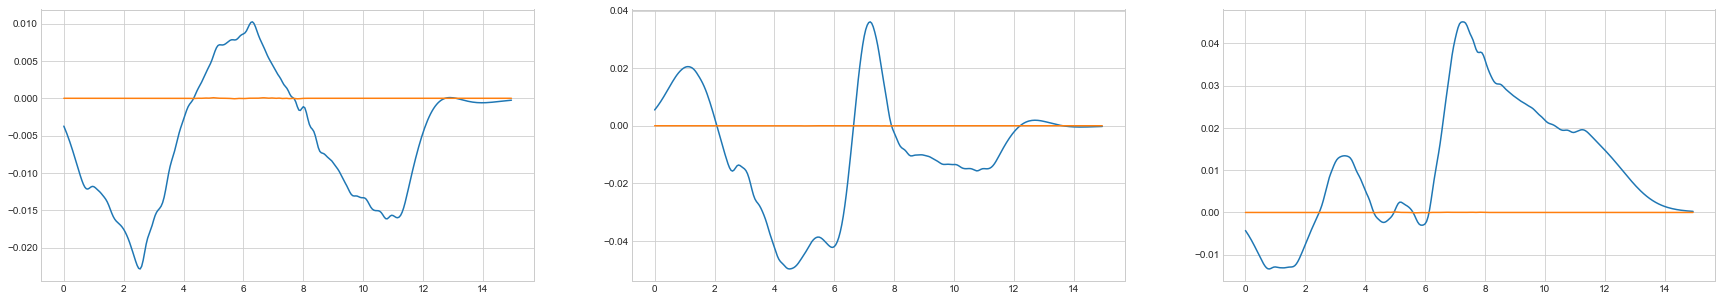

14th additional rbflayer
14th additional RBFlayer 0th epoch loss: 0.027040927566924763


KeyboardInterrupt: 

In [43]:
model_nomal2 = MultiRBFnn(nomal_target2.size(0), 30, device)
model_nomal2.train(input_, nomal_target2, 3000, 0.0001, 0.0001, 0.002)